<a href="https://colab.research.google.com/github/hseghetto/PICME-Deep-Learning/blob/main/coditional_grow_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.__version__

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

#Loading dataset


In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

print(train_images.shape)

(60000, 28, 28, 1)


In [ ]:
upsample = tf.keras.layers.UpSampling2D(size=(2,2))
downsample = tf.keras.layers.AveragePooling2D(pool_size=(2,2))

print(upsample(train_images[0:10]).shape)
print(downsample(train_images[0:10]).shape)

(10, 56, 56, 1)
(10, 14, 14, 1)


In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64
noise_dim = 100

# Batch and shuffle the data
train_dataset14 = tf.data.Dataset.from_tensor_slices((downsample(train_images),train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset28 = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset56 = tf.data.Dataset.from_tensor_slices((upsample(train_images),train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
for images, labels in train_dataset14:
    pass
print(images.shape)
print(labels.shape)

(32, 14, 14, 1)
(32,)


In [ ]:
class WeightedSum(tf.keras.layers.Add):
	# init with default value
	def __init__(self, alpha=0.0, **kwargs):
		super(WeightedSum, self).__init__(**kwargs)
		self.alpha = tf.keras.backend.variable(alpha, name='ws_alpha')
 
	# output a weighted sum of inputs
	def _merge_function(self, inputs):
		# only supports a weighted sum of two inputs
		assert (len(inputs) == 2)
		# ((1-a) * input1) + (a * input2)
		output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
		return output

class LeakyConv2D(layers.Layer):
    def __init__(self, channels, kernel=(5,5), strides=(1,1)):
        super(LeakyConv2D, self).__init__()
        self.Conv = layers.Conv2D(channels, kernel, strides, padding ='same', use_bias=False)
        self.Norm = layers.BatchNormalization()
        self.ReLU = layers.LeakyReLU()

    def call(self, inputs):
        x = self.Conv(inputs)
        x = self.Norm(x)
        out = self.ReLU(x)

        return out

class LeakyConv2DTranspose(layers.Layer):
    def __init__(self, channels, kernel=(5,5), strides=(1,1)):
        super(LeakyConv2DTranspose, self).__init__()
        self.Conv = layers.Conv2DTranspose(channels, kernel, strides, padding ='same', use_bias=False)
        self.Norm = layers.BatchNormalization()
        self.ReLU = layers.LeakyReLU()

    def call(self, inputs):
        x = self.Conv(inputs)
        x = self.Norm(x)
        out = self.ReLU(x)

        return out

class LabelEmbedding(layers.Layer):
    def __init__(self, out_shape, label_dim=10, embed_size=50, label_size=1):
        super(LabelEmbedding, self).__init__()
        self.Embedding = layers.Embedding(label_dim, embed_size ,input_length=label_size) 
        self.Flatten = layers.Flatten()
        self.Dense = layers.Dense(np.prod(out_shape))
        self.Reshape = layers.Reshape(out_shape)
        
    def call(self, inputs):

        x = self.Embedding(inputs)
        x = self.Flatten(x)
        x = self.Dense(x)
        out = self.Reshape(x)

        return out




#Model

##Generator

In [ ]:
def generator_model():
    
    input_shape=(noise_dim,)
    input1 =  layers.Input(input_shape)

    x = layers.Dense(7*7*32, use_bias = False)(input1)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    label = layers.Input(1,)
    y = LabelEmbedding((7*7*32,))(label)

    x = layers.Concatenate()((x,y))

    x = layers.Reshape((7,7,64))(x)
 
    x = LeakyConv2DTranspose(64, strides = (2,2))(x)

    x = LeakyConv2DTranspose(64)(x)

    x = layers.Conv2DTranspose(1, (5, 5), strides=(  1, 1), padding='same', use_bias=False)(x) #to grayscale
    
    
    model = tf.keras.Model([input1,label],x)
    print("Model created succesfully")
    return model

In [ ]:
def generator_expand(old_gen):
    input = old_gen.inputs
    x1 = old_gen.layers[-1].output
    x1 = upsample(x1)

    x2 = old_gen.layers[-1].input
    
    x2 = LeakyConv2DTranspose(64, strides = (2,2))(x2)
    x2 = LeakyConv2DTranspose(64)(x2)

    x2 = layers.Conv2DTranspose(1, (5, 5), strides=(  1, 1), padding='same', use_bias=False)(x2)

    out = WeightedSum()([x1,x2])
    
    model_weighted = tf.keras.Model(input,out)
    model = tf.keras.Model(input,x2)

    return model_weighted, model

Model created succesfully
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1568)         156800      input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 1568)         6272        dense_5[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________

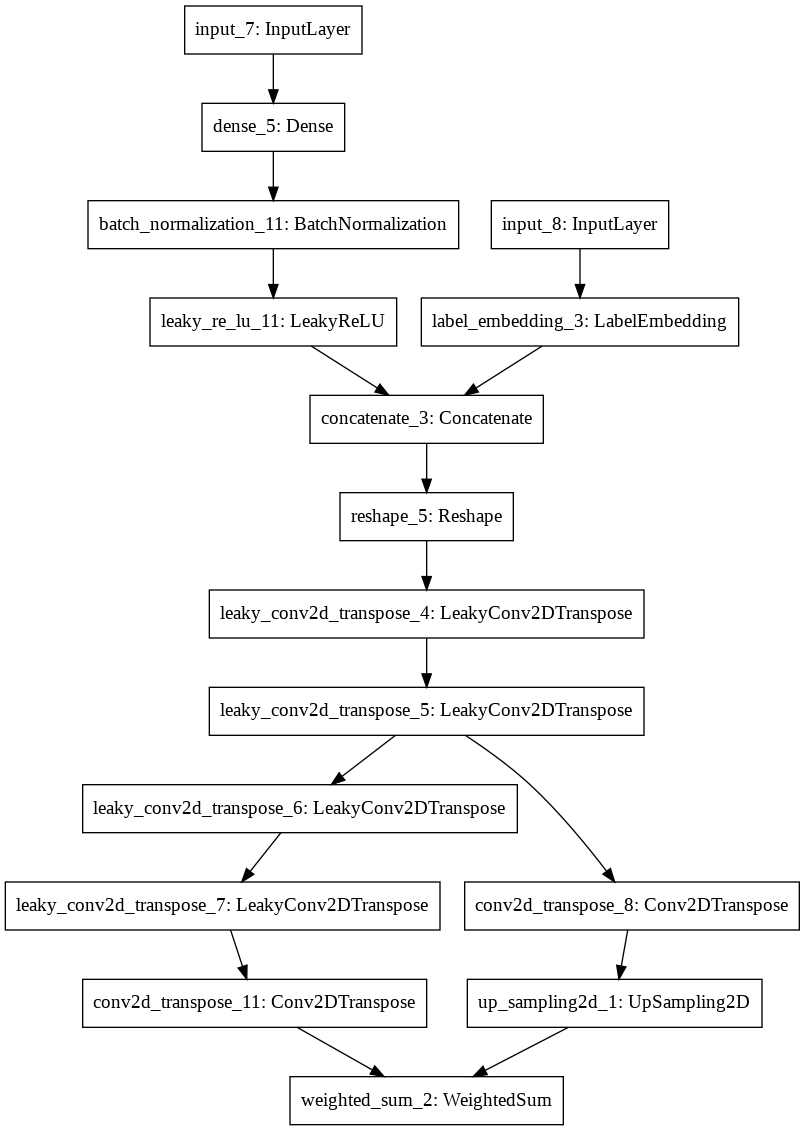

In [ ]:
gen = generator_model()
gen.summary()
tf.keras.utils.plot_model(gen,to_file="gen.png")

new_gen,_ = generator_expand(gen)
new_gen.summary()
tf.keras.utils.plot_model(new_gen,to_file="gen_exp.png")

##Discriminator

In [ ]:
def discriminator_model():
    input_shape = (14,14,1)
    input1 = layers.Input(input_shape)

    x = LeakyConv2D(1)(input1)

    label = layers.Input(1)

    y = LabelEmbedding((14,14,1,))(label)

    x = layers.Concatenate()((x,y))

    x = LeakyConv2D(64)(x)
    x = LeakyConv2D(64,strides = (2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    model = tf.keras.Model((input1,label),x)
    return model

In [ ]:
def discriminator_expand(old_disc):
    size = old_disc.inputs[0].shape[1]*2
    input_shape = (size,size,1)

    input1 = layers.Input(input_shape)
    x1 = LeakyConv2D(1)(input1)

    label = layers.Input(1)
    y1 = LabelEmbedding((size,size,1,))(label)

    x1 = layers.Concatenate()((x1,y1))
    x1 = LeakyConv2D(64)(x1)
    x1 = LeakyConv2D(64, strides=(2,2))(x1)

    x2 = downsample(input1)
    x2 = old_disc.layers[2](x2)

    y2 = old_disc.layers[3](label)
    
    x2 = old_disc.layers[4]((x2,y2))
    x2 = old_disc.layers[5](x2)

    x2 = WeightedSum()((x2,x1))

    for old_layer in old_disc.layers[6:]:
        x1 = old_layer(x1)
        x2 = old_layer(x2)

    model_weighted = tf.keras.Model([input1,label],x2)
    model = tf.keras.Model([input1,label],x1)
    return model_weighted, model


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 14, 14, 1)]  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
leaky_conv2d_6 (LeakyConv2D)    (None, 14, 14, 1)    29          input_9[0][0]                    
__________________________________________________________________________________________________
label_embedding_4 (LabelEmbeddi (None, 14, 14, 1)    10496       input_10[0][0]                   
____________________________________________________________________________________________

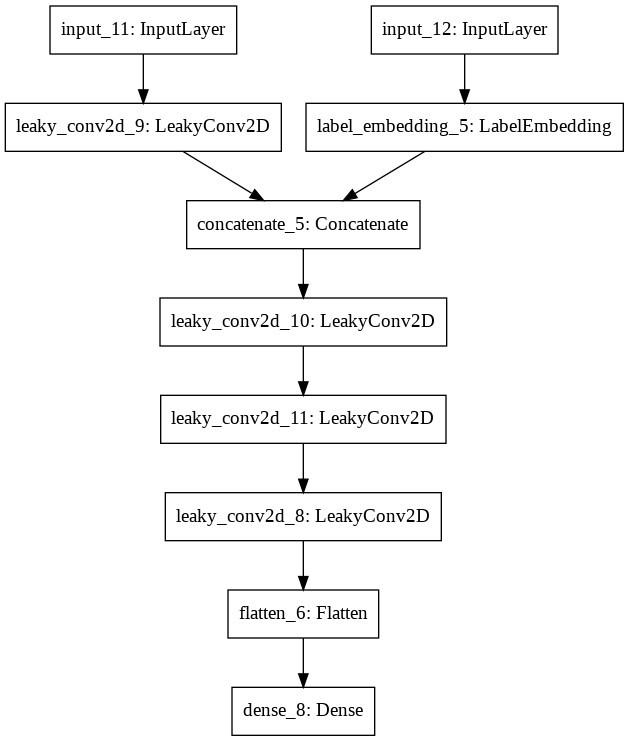

In [ ]:
disc = discriminator_model()

disc.summary()
tf.keras.utils.plot_model(disc,to_file="disc.png")

new_disc, disc = discriminator_expand(disc)

new_disc.summary()
tf.keras.utils.plot_model(disc,to_file="disc_exp.png")

#Optimizer & Losses

In [ ]:
#@tf.function
def generator_loss(fake_output):
    return tf.reduce_sum(fake_output)

In [ ]:
#@tf.function
def discriminator_loss(real_output, fake_output, penalty = 0):
    return tf.reduce_sum(real_output - fake_output) + penalty

In [ ]:
c = 0.1
generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
#discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4,clipnorm = c) #using clipnorm to satisfy WGAN requirements
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4)

#generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-08)
#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-08)

#Training Loop

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
noise = tf.random.normal([num_examples_to_generate, noise_dim])
seed = (noise, labels[0:num_examples_to_generate])

In [ ]:
#@tf.function
def train_step(images,labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator((noise,labels), training=True)

        real_output = discriminator((images,labels), training=True)
        fake_output = discriminator((generated_images,labels), training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
#@tf.function #cant use same tf function with different model shapes
def train_step_gp(images,labels):
    noise = tf.random.normal([images.shape[0], noise_dim])
    e = tf.random.uniform([images.shape[0],1,1,1],minval = 0,maxval = 1)

    with tf.GradientTape(persistent=True) as tape:
        with tf.GradientTape() as penalty_tape:
            generated_images = generator((noise,labels), training=True)

            weighted_images = e*images + (1-e)*generated_images

            weighted_output = discriminator((weighted_images,labels), training = True)

        real_output = discriminator((images,labels), training = True)
        fake_output = discriminator((generated_images,labels), training = True)

        penalty = penalty_tape.gradient(weighted_output,weighted_images) #gradient
        penalty = tf.sqrt(tf.reduce_sum(tf.square(penalty), axis=[1, 2, 3])) #norm
        penalty = 100*tf.reduce_mean(tf.math.square(penalty-1)) # k*(norm -1)^2

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output, penalty)


    gradients_of_generator = tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('nn_{}_step_{}_epoch_{:04d}.png'.format(NN,TRAIN,epoch))
  plt.show()

In [ ]:
def train(dataset,Epochs):

    print("Starting training")
    for epoch in range(Epochs):
        start = time.time()

        #print("Epoch {}".format(epoch+1))

        for image_batch, label_batch in dataset:
            #print(".",end="")
            train_step_gp(image_batch,label_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,seed)
        
        print ("Time for epoch {}/{} is {} sec".format(epoch + 1,Epochs, time.time()-start))

In [ ]:
def train_fade_in(dataset,Epochs):

    print("Starting training with fade-in")
    for epoch in range(Epochs):
        start = time.time()
        #print("Epoch {}".format(epoch+1))

        alpha = (epoch+1)/Epochs #0 to 1
        for image_batch, label_batch in dataset:
            #print(".",end="")
            for layer in discriminator.layers:
                if isinstance(layer,WeightedSum):
                    tf.keras.backend.set_value(layer.alpha,alpha)
            for layer in generator.layers:
                if isinstance(layer,WeightedSum):
                    tf.keras.backend.set_value(layer.alpha,alpha)
            
            train_step_gp(image_batch,label_batch)


        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,seed)
        
        print ("Time for epoch {}/{} is {} sec".format(epoch + 1,Epochs, time.time()-start))

### Testing

(1, 4, 4, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
CPU times: user 370 ms, sys: 7.94 ms, total: 378 ms
Wall time: 381 ms


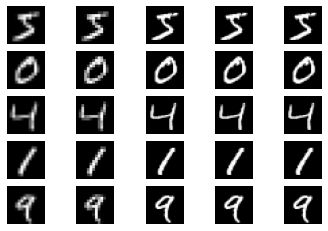

In [ ]:
%%time
for i in range(10):
    image = tf.random.normal([1,2,2,1])
    upsize = upsample(image)
print(upsize.shape)
print(type(upsize))
print(type(image))

for i in range(5):
      plt.subplot(5, 5, 5*i+1)
      plt.imshow(downsample(train_images[i:i+1, :, :, :])[0,:,:,0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

      plt.subplot(5, 5, 5*i+2)
      plt.imshow(upsample(downsample(train_images[i:i+1, :, :, :]))[0,:,:,0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

      plt.subplot(5, 5, 5*i+3)
      plt.imshow(train_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
      
      plt.subplot(5, 5, 5*i+4)
      plt.imshow(downsample(upsample(train_images[i:i+1, :, :, :]))[0,:,:,0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

      plt.subplot(5, 5, 5*i+5)
      plt.imshow(upsample(train_images[i:i+1, :, :, :])[0,:,:,0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

#Model training

In [ ]:
try:
    NN = NN + 0
except:
    NN = 0

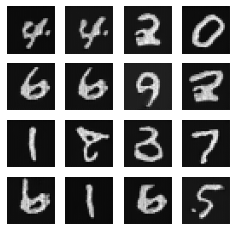

Time for epoch 10/10 is 199.7065782546997 sec


In [ ]:
NN = NN +1
TRAIN = 0

og_train_step = train_step_gp
train_step_gp = tf.function()(og_train_step)

generator = generator_model()
discriminator = discriminator_model()

train(train_dataset14,10)
TRAIN = TRAIN+1

generator,g = generator_expand(generator)
discriminator,d = discriminator_expand(discriminator)

train_step_gp = tf.function()(og_train_step)

train_fade_in(train_dataset28,10)
TRAIN = TRAIN+1

train(train_dataset28,10)
TRAIN = TRAIN+1

generator,g = generator_expand(g)
discriminator,d = discriminator_expand(d)

train_step_gp = tf.function()(og_train_step)

train_fade_in(train_dataset56,10)
TRAIN = TRAIN+1

train(train_dataset56,10)
TRAIN = TRAIN+1

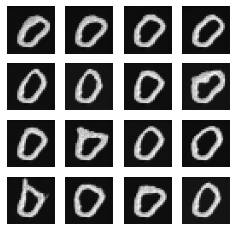

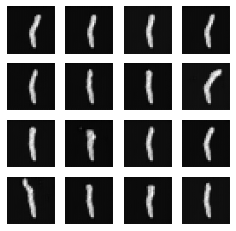

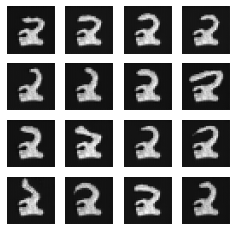

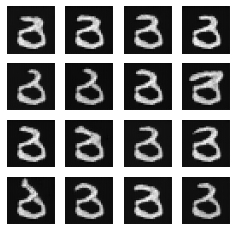

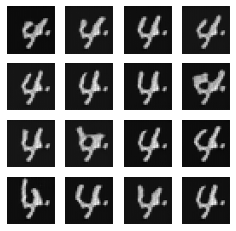

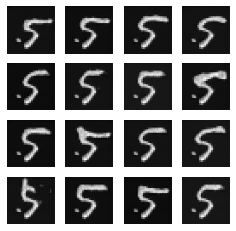

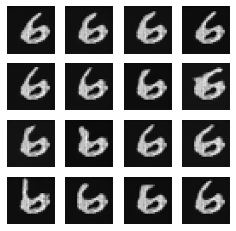

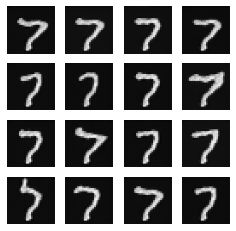

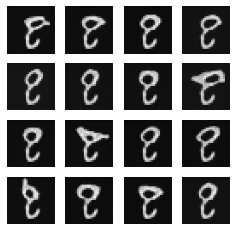

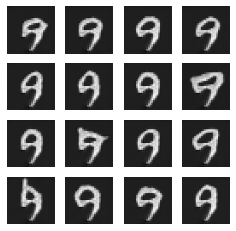

In [ ]:
for i in range(10):
    seed = (noise,tf.ones(num_examples_to_generate)*i)

    predictions = generator(seed, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()